In [85]:
import re
import json
import os
import requests
import toyplot
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

### 1. Use Mountain Project API to get info from 500 routes near El Capitan
I have already saved the results for this example as ElCapitan_data.txt in the same repository as this notebook. To replicate this yourself, you will need a key for the [Mountain Project API](https://www.mountainproject.com/data).

In [146]:
# base URL for Mountain Project API
baseurl = 'https://www.mountainproject.com/data/get-routes-for-lat-lon?'
userKey = None  # your personal key goes here

# latitude and longitude for El Capitan in Yosemite
lat = '37.732'
lon = '-119.638'

url = baseurl + 'lat=' + lat + '&lon=' + lon + '&maxDistance=1&maxResults=500&key=' + userKey

# request info for for all routes on El Capitan
response = requests.get(url)
rdict = response.json()

In [151]:
# get filepath to save response json
curdir = os.path.dirname(os.path.abspath('.'))
filepath = os.path.join(curdir, "climber-net", "ElCapitan_data.txt")

with open(filepath, 'w') as outfile:
    json.dump(rdict, outfile)

### 2. Filter results to only include climbs that are actually on El Capitan

In [4]:
# get filepath to load response json
curdir = os.path.dirname(os.path.abspath('.'))
filepath = os.path.join(curdir, "climber-net", "ElCapitan_data.txt")

# read in from file in parent directory
with open(filepath, 'r') as infile:
    rstring = infile.read()
    
rdict = json.loads(rstring)

In [5]:
# convert to pandas df
df = pd.DataFrame(rdict['routes'])

# filter results to only include climbs on El Capitan
def ElCap(x):
    return 'El Capitan' in x

climbs = df.loc[df['location'].apply(ElCap)]

### 3. Use BeautifulSoup to get FA info from all climbs

In [6]:
def FA_split(string):
    split = re.split(', |: | and |, and | & |-| - |- |\(', string)
    
    return(split)

In [7]:
# data frame to hold all climbs and first ascentionists
zero_data = np.zeros(shape=(len(climbs), 2))
firsts = pd.DataFrame(zero_data, columns=['name', 'FA'])

len(firsts)

# iterate through climbs and record FAs
for i in range(len(firsts)):
    # get unique page for climb
    url = climbs.url.iloc[i]
    response = requests.get(url)
    
    # use BeautifulSoup to find FA field in HTML
    soup = BeautifulSoup(response.text, "html5lib")
    
    details = soup.find_all("table", {"class", "description-details"})    

    for detail in details:
        tdtag = detail.find('tbody')
    
    FAs = tdtag.contents[2].contents[3].contents[0].strip()
    
    # set name and FA in firsts df
    firsts.name.loc[i] = climbs.name.iloc[i]
    firsts.FA.loc[i] = FA_split(FAs)
    
firsts

C:\Users\Alex\Miniconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,name,FA
0,The Nose,"[FA, Warren Harding, Wayne Merry, George Whitm..."
1,Salathe Wall,"[Royal Robbins, Tom Frost, Chuck Pratt 1961 F..."
2,Zodiac,"[Charlie Porter, 1972, ?)]"
3,Sacherer Cracker,"[FFA, Frank Sacherer, Mike Sherrick, 1964]"
4,East Buttress,"[Allen Steck, Wili Siri, Dick Long, Willi Unso..."
5,Salathe (pitch 1),"[Royal Robbins, Chuck Pratt, Tom Frost 1961]"
6,Lurking Fear,"[Dave Bircheff, Phil Bircheff, and Jim Pettigr..."
7,Moby Dick,"[FA, Herb Swedlund, Penny Carr, 5/63 FFA, Fr..."
8,Freeblast,"[Jim Bridwell, John Long, Kevin Worrall, Mike ..."
9,"La Cosita, Right","[TM Herbert, Steve Roper, May 1963.]"


In [8]:
def FA_clean(FAlist):
    # find first list element containing a digit
    for i in range(len(FAlist)):
        if bool(re.search(r'\d', FAlist[i])):
            # if it is first element, ignore it
            if i == 0:
               pass
                
            # if it is not first element, check if first char is number
            else:
                # if first char, remove that element and all elements after
                if FAlist[i][0].isdigit():
                    newlist = FAlist[:i]
                    break
                
                # if not first char, split and remove digits and all elements after
                else:
                    #print('digit not in char 0 - split and remove digits and later elements')
                    newlist = FAlist[:i + 1]
                    for j in range(len(FAlist[i])):
                        if FAlist[i][j].isdigit():
                            newlist[i] = FAlist[i][:j-1]
                            break
                    break
        else:
            newlist = FAlist

    return(newlist)

In [10]:
clean = firsts.FA.apply(FA_clean)

# fix errors missed by FA_clean
clean[0] =  ['Warren Harding', 'Wayne Merry', 'George Whitmore']
clean[3] =  ['Frank Sacherer', 'Mike Sherrick']
clean[4] =  ['Allen Steck', 'Will Siri', 'Dick Long', 'Willi Unsoeld']
clean[5] =  ['Royal Robbins', 'Chuck Pratt', 'Tom Frost ']
clean[6] =  ['Dave Bircheff', 'Phil Bircheff', 'Jim Pettigrew']
clean[7] =  ['Herb Swedlund', 'Penny Carr']
clean[9] =  ['TM Herbert', 'Steve Roper']
clean[10] = ['Jack Turner', 'Royal Robbins']
clean[12] = ['Bob Kamps', 'Galen Rowell', 'Dan Doody', 'Wally Upton']
clean[14] = ['TM Herbert', 'Royal Robbins']
clean[16] = ['Alexander Huber', 'Thomas Huber']
clean[18] = ['Gary Bocarde', 'Charlie Porter']
clean[19] = ['Jim Bridwell', 'Kim Schmitz']
clean[21] = ['Charlie Porter', 'John-Paul de St. Croix']
clean[22] = ['Dale Bard']
clean[23] = ['Tobin Sorenson', 'John Bachar']
clean[24] = ['Alexander Huber', 'Max Reichel']
clean[25] = ['Royal Robbins', 'Yvon Chouinard', 'Chuck Pratt', 'Tom Frost']
clean[27] = ['Mason Earle', 'Brad Gobright']
clean[28] = ['Hugh Burton', 'Steve Sutton']
clean[29] = ['Walter Rosenthal', 'Tom Carter', 'Alan Bard']
clean[30] = ['Charlie Row', 'Bill Price', 'Guy Thompson']
clean[34] = ['Jacek Czyz']
clean[37] = ['Mead Hargis', 'Kim Schmitz']
clean[39] = ['Rick Lovelace']
clean[40] = ['Bruce Hawkins', 'Mark Chapman']
clean[43] = ['Bob Kamps', 'Jim Sims']
clean[46] = ['Tommy Caldwell', 'Kevin Jorgeson']
clean[47] = ['Yvon Chouinard', 'TM Herbert']
clean[48] = ['Joe Kelsey', 'Roman Laba', 'John Hudson']
clean[49] = ['Jim Beyer']
clean[50] = ['Chuck Pratt', 'Royal Robbins']
clean[53] = ['Mark Corbett', 'Gary Edmondson', 'Rich Albuschkat']

firsts.FA = clean

### 4. Bar graph of climbs by first ascentionists on El Capitan

In [16]:
climbers = []

for i in range(len(clean)):
    climbers = climbers + clean.loc[i]

arr = np.unique(climbers, return_counts=True)
arr = np.core.records.fromarrays(arr)

counts = np.sort(arr, order='f1')[::-1]
counts[:25]

rec.array([('Royal Robbins', 6), ('Jim Bridwell', 5), ('TM Herbert', 4),
           ('Chuck Pratt', 4), ('Charlie Porter', 4), ('Bob Kamps', 4),
           ('Yvon Chouinard', 3), ('Kim Schmitz', 3),
           ('Frank Sacherer', 3), ('Will Siri', 2), ('Wally Upton', 2),
           ('Troy Johnson', 2), ('Tom Frost', 2), ('Steve Sutton', 2),
           ('Steve Roper', 2), ('Mark Chapman', 2), ('John Bachar', 2),
           ('Jim Pettigrew', 2), ('Hugh Burton', 2), ('Galen Rowell', 2),
           ('Dan Doody', 2), ('Charlie Row', 2), ('Allen Steck', 2),
           ('Alexander Huber', 2), ('unknown', 1)],
          dtype=[('f0', '<U22'), ('f1', '<i8')])

In [18]:
canvas = toyplot.Canvas(700, 500)
axis = canvas.cartesian()
axis.bars(range(24), counts.f1[:24], title=counts.f0[:24]);

Royal Robbins Jim Bridwell TM Herbert Chuck Pratt Charlie Porter Bob Kamps Yvon Chouinard Kim Schmitz Frank Sacherer Will Siri Wally Upton Troy Johnson Tom Frost Steve Sutton Steve Roper Mark Chapman John Bachar Jim Pettigrew Hugh Burton Galen Rowell Dan Doody Charlie Row Allen Steck Alexander Huber 0 10 20 0 2 4 6

### 5. Create a unipartite network of climbers

In [26]:
# create list of edges for networkx
edges = []

for i in range(len(firsts)):
    name = firsts.name.iloc[i]

    for climber in firsts.FA.iloc[i]:
        edge = (name, climber)
        edges.append(edge)

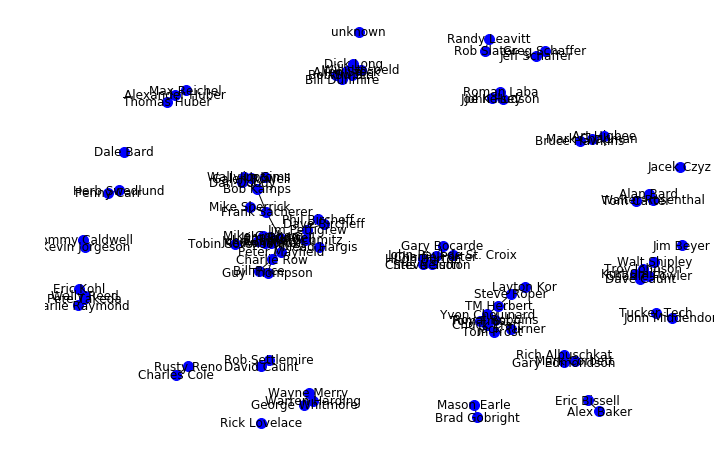

In [103]:
climbs = list(set(firsts.name.values.tolist()))
FAs = list(set(climbers))

# build a bipartite graph:
B = nx.Graph()
B.add_nodes_from(climbs, bipartite=0)
B.add_nodes_from(FAs, bipartite=1)
B.add_edges_from(edges)

# project one side of the graph:
G = nx.projected_graph(B, FAs)

#pos = nx.spring_layout(G)

newlabel = {}

netlabel = nx.draw_networkx_labels(G, pos)#labels, pos)
for label in netlabel:
    if label not in dict(counts[:24]):
        newlabel[label] = ''
    else:
        newlabel[label] = label

plt.figure(1, size=(14, 10))
        
nx.draw(G, pos=pos, with_labels=False, node_color = '#0000FF88', node_size = 100)

In [55]:
G.edges

EdgeView([('Charlie Porter', 'John-Paul de St. Croix'), ('Charlie Porter', 'Steve Sutton'), ('Charlie Porter', 'Chris Nelson'), ('Charlie Porter', 'Gary Bocarde'), ('Charlie Porter', 'Hugh Burton'), ('Charlie Fowler', 'Kurt Smith '), ('Charlie Fowler', 'Troy Johnson'), ('Charlie Fowler', 'Dave Caunt'), ('Steve Sutton', 'Chris Nelson'), ('Steve Sutton', 'Hugh Burton'), ('Art Higbee', 'Mark Chapman'), ('David Caunt', 'Rob Settlemire'), ('Layton Kor', 'Steve Roper'), ('Mike Graham', 'John Bachar'), ('Mike Graham', 'John Long'), ('Mike Graham', 'Jim Bridwell'), ('Mike Graham', 'Ron Kauk'), ('Mike Graham', 'Kevin Worrall'), ('Bob Swift', 'Bill Dunmire'), ('Bob Swift', 'Will Siri'), ('Bob Swift', 'Allen Steck'), ('Randy Leavitt', 'Rob Slater'), ('Bill Price', 'Guy Thompson'), ('Bill Price', 'Charlie Row'), ('Hugh Burton', 'Chris Nelson'), ('Kevin Worrall', 'John Bachar'), ('Kevin Worrall', 'John Long'), ('Kevin Worrall', 'Jim Bridwell'), ('Kevin Worrall', 'Ron Kauk'), ('Allen Steck', 'Will S

In [89]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)

[12.0, 8.0]
